# Olist : clusterisation

In [56]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import davies_bouldin_score

In [2]:
data = pd.read_csv('data/olist_customers_whole.csv')

In [3]:
data.head()

,customer_unique_id,first_purchase,last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_unique_id    96096 non-null  object 
 1   first_purchase        96096 non-null  object 
 2   last_purchase         96096 non-null  object 
 3   total_orders          96096 non-null  int64  
 4   total_spent           96095 non-null  float64
 5   average_review_score  279 non-null    float64
 6   all_comments          120 non-null    object 
 7   total_price_items     95420 non-null  float64
 8   total_freight_value   95420 non-null  float64
 9   product_categories    94107 non-null  object 
 10  seller_cities         95420 non-null  object 
 11  order_statuses        96096 non-null  object 
dtypes: float64(4), int64(1), object(7)
memory usage: 8.8+ MB


In [5]:
data['average_review_score'].describe()

count    279.000000
mean       4.014337
std        1.429321
min        1.000000
25%        3.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: average_review_score, dtype: float64

In [6]:
#needs to translate last_purchase into datetime for later use
columns_to_translate_into_datetime = ['last_purchase', 'first_purchase']

data[columns_to_translate_into_datetime] = data[columns_to_translate_into_datetime].apply(pd.to_datetime)

In [7]:
#How many different product categories are there
pc = data['product_categories']
pc.nunique()

668

#### Making sure there's no NAN

In [8]:
# Missing values exploration
def null_table(df):
    missing_values = df.isnull().sum()
    missing_values_percent = (missing_values*100)/len(df)
    table = pd.concat([missing_values, missing_values_percent], axis=1)
    table_renamed = table.rename(
        columns = {0 : "Missing Values", 1  : "Percentage of total"})
    final_table = table_renamed[table_renamed.iloc[:,0] != 0].sort_values(
        by='Missing Values', ascending=False).round(2)
    
    return final_table

In [9]:
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
total_price_items,676,0.70
total_freight_value,676,0.70
seller_cities,676,0.70
total_spent,1,0.00


In [10]:
# removing nan from the features we will use
median_price = data['total_price_items'].median()
median_total_spent = data['total_spent'].median()
data['total_price_items'] = data['total_price_items'].fillna(median_price)
data['total_spent'] = data['total_spent'].fillna(median_price)
null_table(data)

,Missing Values,Percentage of total
all_comments,95976,99.88
average_review_score,95817,99.71
product_categories,1989,2.07
total_freight_value,676,0.70
seller_cities,676,0.70


<function matplotlib.pyplot.show(close=None, block=None)>

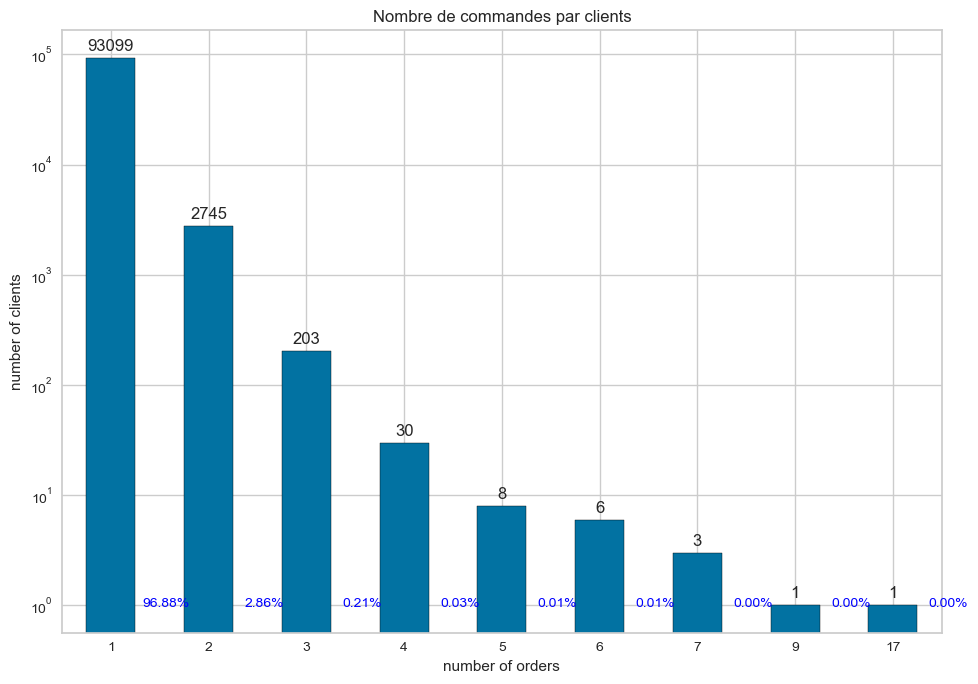

In [11]:
#plotting the number of orders by clients
fig = plt.figure(figsize=(10, 7))
x = data['total_orders'].value_counts().sort_index()
total = x.sum()
ax = x.plot(kind='bar', edgecolor='black')

for xaxis, yaxis in enumerate(x):
    ax.annotate(str(yaxis), xy=(xaxis, yaxis),  xytext=(0, 5), textcoords='offset points', ha='center')

for xaxis, yaxis in enumerate(x):
    percentage = (yaxis / total) * 100
    ax.annotate(f'{percentage:.2f}%', xy=(xaxis, 1),  xytext=(40, 5), textcoords='offset points', ha='center', va='top', fontsize=10, color='blue')

plt.yscale('log')
plt.xlabel('number of orders')
plt.xticks(rotation=0)
plt.ylabel('number of clients')
plt.title('Nombre de commandes par clients')
plt.tight_layout()

plt.show

piechart : 1 commande VS les autres

On constate qu'à peine plus que 3% des clients on fait plus qu'une seule commande

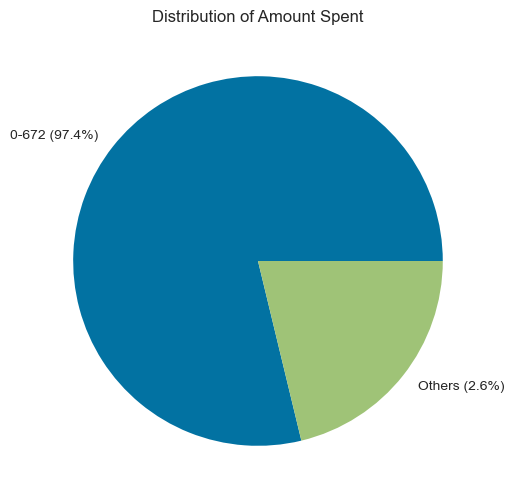

In [12]:
# Calculate the bin edges and counts
n, bins = np.histogram(data['total_price_items'], bins=20)

# Calculate the total amount spent in each bin
bin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]

# Calculate the percentage of people in each bin
total_people = len(data)
percent_people = [(data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].count() / total_people) * 100 for i in range(len(bins)-1)]

# Create labels for the pie chart
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])} ({percent_people[i]:.1f}%)' for i in range(len(bins)-1)]

# Group the bins with small percentages into an 'Others' category
threshold = 5  # percentage

# Initialize lists for the new labels and totals
new_bin_totals = []
new_bin_labels = []

# Track totals for 'Others' category
others_total = 0
others_percentage = 0

# Iterate through the bins and group small percentages
for total, label, percentage in zip(bin_totals, bin_labels, percent_people):
    if percentage >= threshold:
        new_bin_totals.append(total)
        new_bin_labels.append(label)
    else:
        others_total += total
        others_percentage += percentage

# Add the 'Others' category if needed
if others_total > 0:
    new_bin_totals.append(others_total)
    new_bin_labels.append(f'Others ({others_percentage:.1f}%)')

# Create the pie chart with the new bins
plt.figure(figsize=(10, 6))
plt.pie(new_bin_totals, labels=new_bin_labels, startangle=0)
plt.title('Distribution of Amount Spent')
plt.show()

In [13]:
'''# Calculate the bin edges and counts
n, bins = np.histogram(data['total_price_items'], bins=30)

# Calculate the total amount spent in each bin
bin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]

# Calculate the percentage of people in each bin
total_people = len(data)
percent_people = [i / len(data) *100 for i in n]

percent_people'''

"# Calculate the bin edges and counts\nn, bins = np.histogram(data['total_price_items'], bins=30)\n\n# Calculate the total amount spent in each bin\nbin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]\n\n# Calculate the percentage of people in each bin\ntotal_people = len(data)\npercent_people = [i / len(data) *100 for i in n]\n\npercent_people"

In [14]:
'''bin_labels = [f'{np.round(bins[i])}-{np.round(bins[i+1])}' for i in range(len(bins)-1)]
other = []

for i, j in zip(percent_people, bin_labels):
    if i < 1:
        other.append(j)

other'''

"bin_labels = [f'{np.round(bins[i])}-{np.round(bins[i+1])}' for i in range(len(bins)-1)]\nother = []\n\nfor i, j in zip(percent_people, bin_labels):\n    if i < 1:\n        other.append(j)\n\nother"

In [15]:
'''# Calculate the bin edges and counts
n, bins = np.histogram(data['total_price_items'], bins=20)

# Calculate the total amount spent in each bin
bin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]

# Create labels for the pie chart
bin_labels = [f'{np.round(bins[i])}-{np.round(bins[i+1])}' for i in range(len(bins)-1)]

# Create the pie chart
plt.figure(figsize=(10, 6))
plt.pie(bin_totals, labels=bin_labels, autopct='%1.1f%%')
plt.title('Distribution of Amount Spent')
plt.show()'''

"# Calculate the bin edges and counts\nn, bins = np.histogram(data['total_price_items'], bins=20)\n\n# Calculate the total amount spent in each bin\nbin_totals = [data['total_price_items'][(data['total_price_items'] >= bins[i]) & (data['total_price_items'] < bins[i+1])].sum() for i in range(len(bins)-1)]\n\n# Create labels for the pie chart\nbin_labels = [f'{np.round(bins[i])}-{np.round(bins[i+1])}' for i in range(len(bins)-1)]\n\n# Create the pie chart\nplt.figure(figsize=(10, 6))\nplt.pie(bin_totals, labels=bin_labels, autopct='%1.1f%%')\nplt.title('Distribution of Amount Spent')\nplt.show()"

In [16]:
'''#Plotting the amount spent distribution
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(data['total_price_items'], bins=20, edgecolor='black')
# Calculate the bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

#Amount of clients in each bins
for count, bin_edge in zip(n, bins[:-1]):
    if count > 0:  #only for non-empty bins
        plt.annotate(f'{int(count)}', xy=(bin_edge + (bins[1] - bins[0])/2, count), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)

#Mean amount spent in each bin
bin_indices = np.digitize(data['total_price_items'], bins) #NOTE DOWN np.digitize METHOD !! 
bin_means = [data['total_price_items'][bin_indices == i].mean() for i in range(1, len(bins))]

#Annotate mean amount spent in each bin
for bin_mean, bin_center in zip(bin_means, bin_centers):
    plt.annotate(f'{bin_mean:.2f}', xy=(bin_center, n[np.where(bin_centers == bin_center)][0]), xytext=(5, 15), textcoords='offset points', ha='center', fontsize=10, color='green', rotation=45)

#Client percentage in each bins
total_clients = len(data)
for count, bin_center in zip(n, bin_centers):
    percentage_clients = (count / total_clients) * 100
    plt.annotate(f'{percentage_clients:.1f}%', xy=(bin_center, 1), xytext=(0, -40), textcoords='offset points', ha='center', va='top', fontsize=10, color='red', rotation=45)

plt.xlabel('Montant dépensé')
plt.ylabel('Nombre de commandes')
plt.yscale('log')
plt.title('Distribution des montants dépensés')
plt.tight_layout()
plt.show()'''

"#Plotting the amount spent distribution\nplt.figure(figsize=(10, 6))\nn, bins, patches = plt.hist(data['total_price_items'], bins=20, edgecolor='black')\n# Calculate the bin centers\nbin_centers = 0.5 * (bins[:-1] + bins[1:])\n\n#Amount of clients in each bins\nfor count, bin_edge in zip(n, bins[:-1]):\n    if count > 0:  #only for non-empty bins\n        plt.annotate(f'{int(count)}', xy=(bin_edge + (bins[1] - bins[0])/2, count), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=10)\n\n#Mean amount spent in each bin\nbin_indices = np.digitize(data['total_price_items'], bins) #NOTE DOWN np.digitize METHOD !! \nbin_means = [data['total_price_items'][bin_indices == i].mean() for i in range(1, len(bins))]\n\n#Annotate mean amount spent in each bin\nfor bin_mean, bin_center in zip(bin_means, bin_centers):\n    plt.annotate(f'{bin_mean:.2f}', xy=(bin_center, n[np.where(bin_centers == bin_center)][0]), xytext=(5, 15), textcoords='offset points', ha='center', fontsize=10, color

distribution plot : 'a quel point les montants sont éloigné de la moyenne'

En tant que ML => on s'assure que nos features tendent vers une loi normale

96.7% des clients ont un panier moyen de 120 Reals

### RFM : Récence Fréquence Montant

In [17]:
#Recence

#calculate the time since last seen
current_date = pd.to_datetime(datetime.now().date()) #maybe not use the current date but last date of DB update ('2021-10-01')
data['days_since_last_purchase'] = (current_date - data['last_purchase']).dt.days

# Insert the new column after the last_seen column
last_purchase_index = data.columns.get_loc('last_purchase')
data.insert(last_purchase_index + 1, 'days_since_last_purchase', data.pop('days_since_last_purchase'))

data.head()

,customer_unique_id,first_purchase,last_purchase,days_since_last_purchase,total_orders,total_spent,average_review_score,all_comments,total_price_items,total_freight_value,product_categories,seller_cities,order_statuses
0,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15 23:30:03,2018-08-20 19:14:26,2123,17,927.63,NaN,NaN,729.62,172.42,"construcao_ferramentas_ferramentas, esporte_la...","campinas, curitiba, joinville, londrina, sao j...","delivered, shipped, unavailable"
1,3e43e6105506432c953e165fb2acf44c,2017-09-18 18:53:15,2018-02-27 18:36:39,2297,9,1963.58,NaN,NaN,1000.85,171.82,"cama_mesa_banho, casa_construcao, informatica_...","ibitinga, jaguariuna, porto alegre, rio de jan...",delivered
2,6469f99c1f9dfae7733b25662e7f1782,2017-09-19 01:02:44,2018-06-28 00:43:34,2176,7,973.09,NaN,NaN,664.20,94.63,cama_mesa_banho,"ibitinga, piracicaba, sao paulo",delivered
3,ca77025e7201e3b30c44b472ff346268,2017-10-09 12:34:39,2018-06-01 11:38:29,2203,7,2126.44,NaN,NaN,806.61,316.11,"cama_mesa_banho, cool_stuff, moveis_decoracao,...","ibitinga, pedreira, sao paulo",delivered
4,1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13 16:44:41,2018-02-14 13:22:12,2310,7,1386.54,NaN,NaN,855.21,165.91,"beleza_saude, moveis_decoracao, papelaria, per...","formiga, itajai, mogi das cruzes, pedreira, sa...",delivered


Features RFM retenues : 
- last_purchase = Récence
- days_since_last_purchase = Fréquence
- total_price_items = Montant

In [18]:
#New df with only the 3 needed features
columns_RFM = ['last_purchase', 'days_since_last_purchase', 'total_price_items']
data_RFM = data[columns_RFM]

data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,2018-08-20 19:14:26,2123,729.62
1,2018-02-27 18:36:39,2297,1000.85
2,2018-06-28 00:43:34,2176,664.20
3,2018-06-01 11:38:29,2203,806.61
4,2018-02-14 13:22:12,2310,855.21
...,...,...,...
96091,2018-06-06 10:46:09,2198,223.00
96092,2017-12-17 23:31:33,2369,59.00
96093,2017-08-04 23:18:15,2504,143.80
96094,2018-08-12 20:27:59,2131,30.00


#### Moving on : standardscaling

In [19]:
#Can't standardscale the datetime column
data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())

C:\Users\kanam\AppData\Local\Temp\ipykernel_15112\1263757375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_RFM['last_purchase'] = data_RFM['last_purchase'].apply(lambda x: x.timestamp())


In [20]:
data_RFM

,last_purchase,days_since_last_purchase,total_price_items
0,1.534792e+09,2123,729.62
1,1.519757e+09,2297,1000.85
2,1.530147e+09,2176,664.20
3,1.527853e+09,2203,806.61
4,1.518615e+09,2310,855.21
...,...,...,...
96091,1.528282e+09,2198,223.00
96092,1.513553e+09,2369,59.00
96093,1.501889e+09,2504,143.80
96094,1.534106e+09,2131,30.00


In [21]:
scaler = StandardScaler()
data_RFM_scaled = scaler.fit_transform(data_RFM)

In [22]:
'''#silhouette score on 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
silhouette_score(data_RFM_scaled, kmeans.fit_predict(data_RFM))

#takes 177 seconds to run'''

C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\kanam\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


0.5002650855700495

In [23]:
'''
#Maybe not needed because there are graphs later
#silhouette score on range 2 - 12
for k in range (2, 13):
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
    sscore = silhouette_score(data_RFM_scaled, kmeans.fit_predict(data_RFM_scaled))
    print(f'Silhouette score for {k} clusters is {sscore}')'''

"\n#Maybe not needed because there are graphs later\n#silhouette score on range 2 - 12\nfor k in range (2, 13):\n    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')\n    sscore = silhouette_score(data_RFM_scaled, kmeans.fit_predict(data_RFM_scaled))\n    print(f'Silhouette score for {k} clusters is {sscore}')"

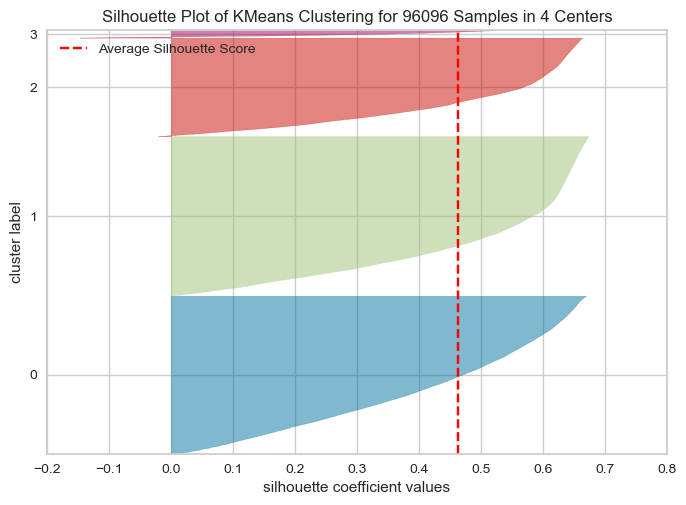

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 96096 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [24]:
#density visualizer Silhouette on 5 clusters
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show() 

silhouette is way longer than Elbow

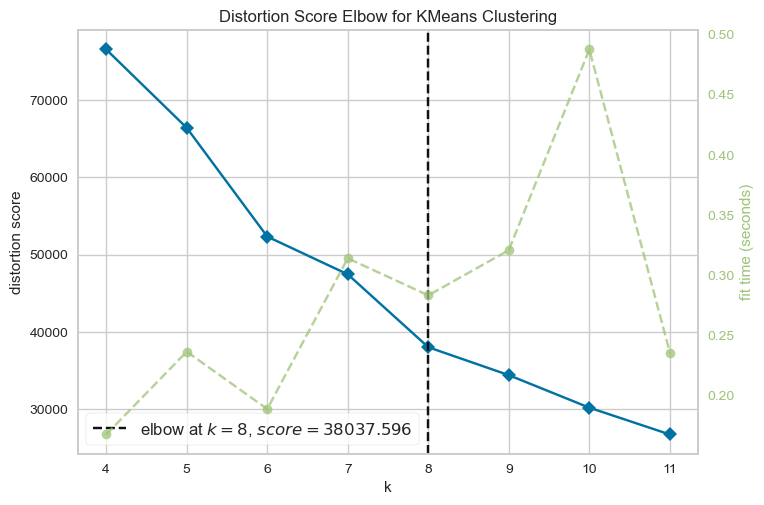

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [25]:
'''model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show()'''

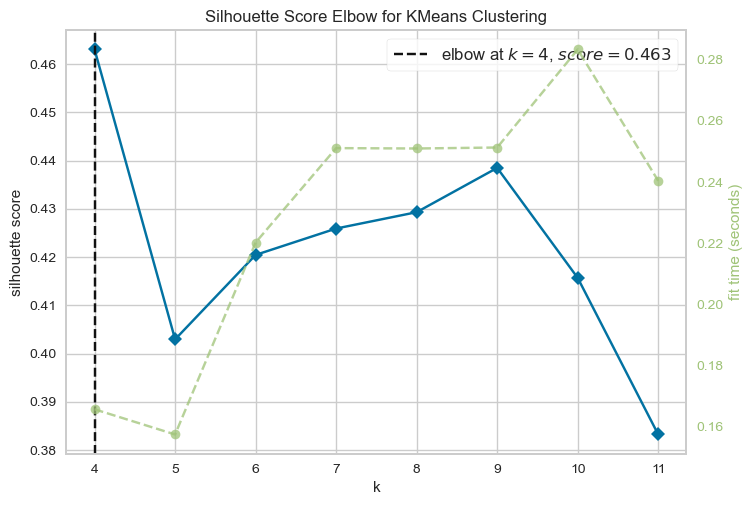

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [26]:
'''model = KMeans()
visualizer = KElbowVisualizer(model, metric='silhouette', k=(4,12))

visualizer.fit(data_RFM_scaled)        # Fit the data to the visualizer
visualizer.show()'''

distortion score + davis bouldin + score silhouette sur le meme graph \
pipeline = standardscaler + reentrainement kmeans final

In [27]:
# pipeline
best_k = 4

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10, init='k-means++'))
])

'''# Fit the pipeline to the data
pipeline.fit(data_RFM)

cluster_labels = pipeline.predict(data_RFM)
print(cluster_labels)'''

'# Fit the pipeline to the data\npipeline.fit(data_RFM)\n\ncluster_labels = pipeline.predict(data_RFM)\nprint(cluster_labels)'

In [28]:
#Need to test function
def train_kmeans(scaler, data, best_k):
    pipeline = Pipeline([
    ('scaler', scaler.fit_transform(data)),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10, init='k-means++'))
])
    return pipeline.fit(data)

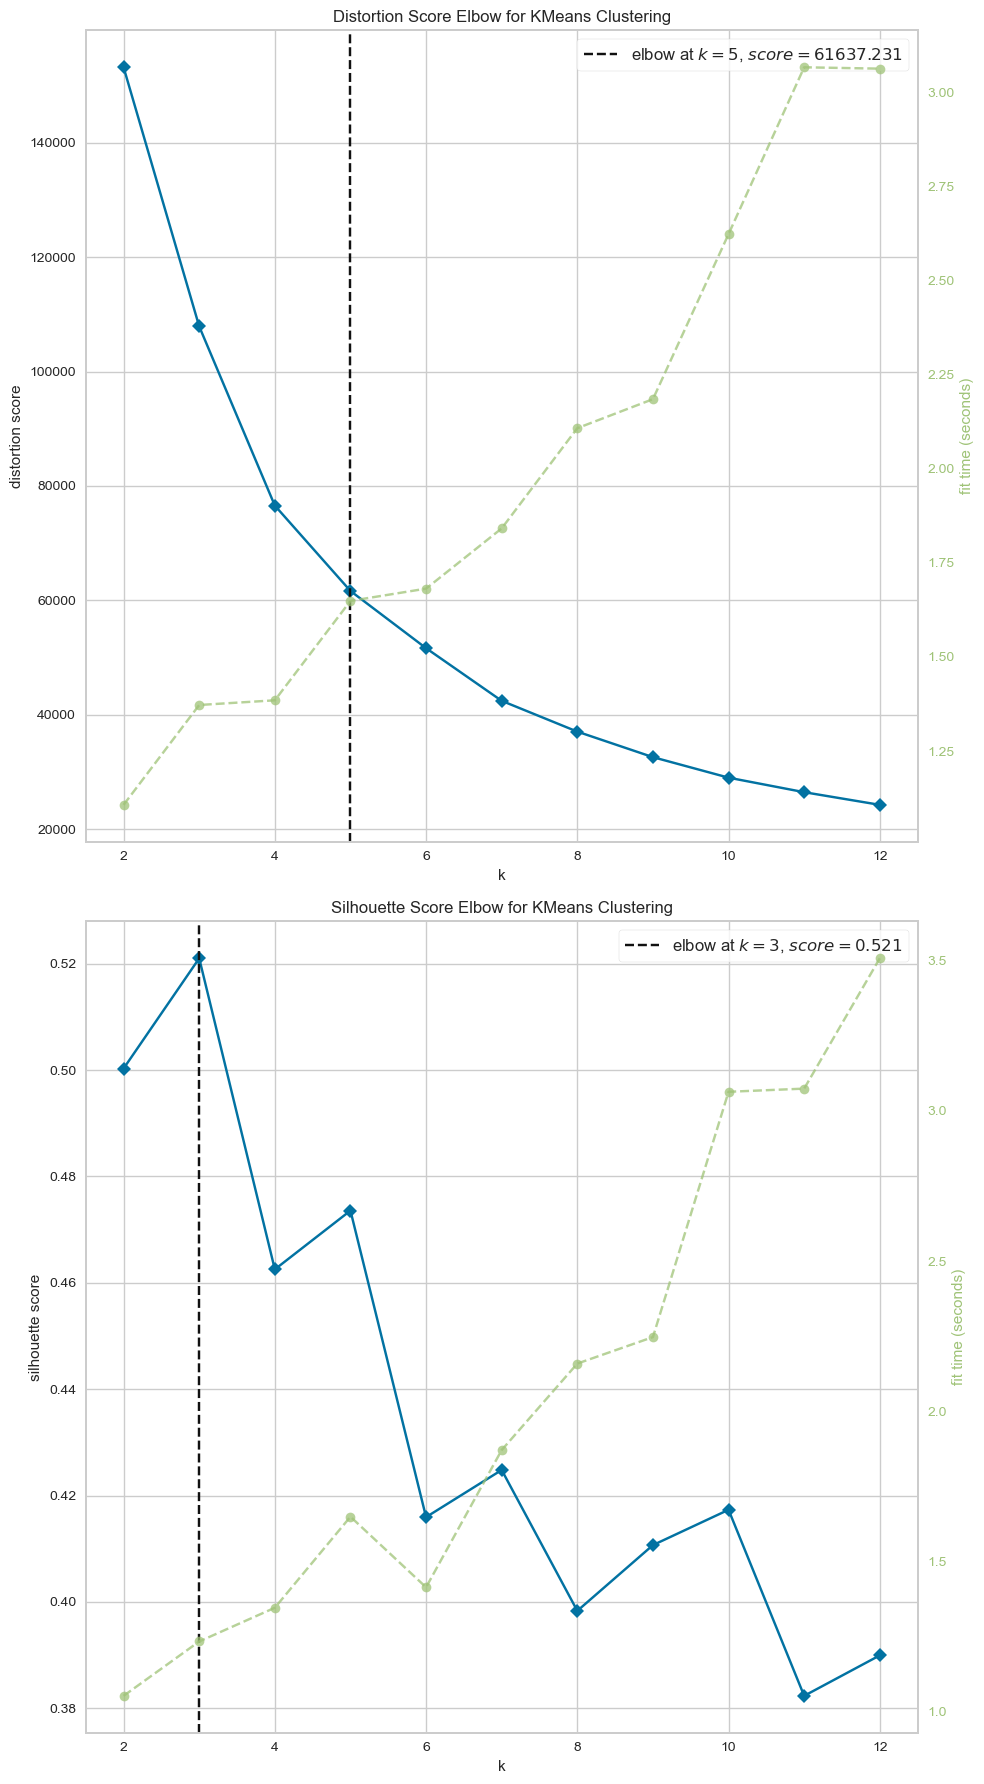

In [31]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 18))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM_scaled)
elbow_visualizer.finalize()

# Silhouette Score
km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(km, k=cluster_range, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM_scaled)
visualizer.finalize()

plt.tight_layout()
plt.show()

Optimal K confirmed between 4 and 2 ? 3 et 5 ? probably 5

Using the total number of clients is not necessarily relevant, due to the only one purchase made bringing very little information

Using only the multiple times buyer :
pros = better information
cons = 97% of data is unusable (only 3000 customers)

Not reasonnably feasable, but worth to mention to olist teams

Adding features : 

- total_orders => indicates if customers returns to olist, and how much so.
- I don't like the all_comments and review_score features, as they are very limited (120 and 279 non-null only)
- total_freight_value => is the client ready to spend with olist despite the distance and increased freigth tarification

Rework the SQL query to include more features ?

récupérer le label attribué avec .labels_
merge avec le dataframe
ensuite groupby cluster pour les analyses
analyse bivariés => corrélation (pearson)

boxplots : feature par cluster ET cluster par features

diagramme RADAR feature par cluster

Enrichir le jeu de données => total_orders / total_freight_value

A tester 
DBSCAN => répartition étrange des clusters => trop peu de données pertinentes
CAH => difficile à faire tourner => n'utiliser que 5% du dataset => Très puissant mais trop gourmand

+ review et correction de code

In [32]:
pipeline.fit(data_RFM_scaled)
data_RFM['cluster'] = pipeline.predict(data_RFM_scaled)

C:\Users\kanam\AppData\Local\Temp\ipykernel_15112\4171085425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_RFM['cluster'] = pipeline.predict(data_RFM_scaled)


In [33]:
data_RFM.head()

,last_purchase,days_since_last_purchase,total_price_items,cluster
0,1.534792e+09,2123,729.62,0
1,1.519757e+09,2297,1000.85,3
2,1.530147e+09,2176,664.20,0
3,1.527853e+09,2203,806.61,0
4,1.518615e+09,2310,855.21,3


#### Analyse par cluster

In [34]:
data_cluster = data_RFM.groupby('cluster')
cluster_repartition = (data_cluster['cluster'].value_counts() / len(data_RFM))*100
cluster_repartition

cluster
0    37.805944
1    23.113345
2    37.440684
3     1.640027
Name: count, dtype: float64

On note une grande irrégularité, un des cluster est très peu peuplé

#### Feature by cluster

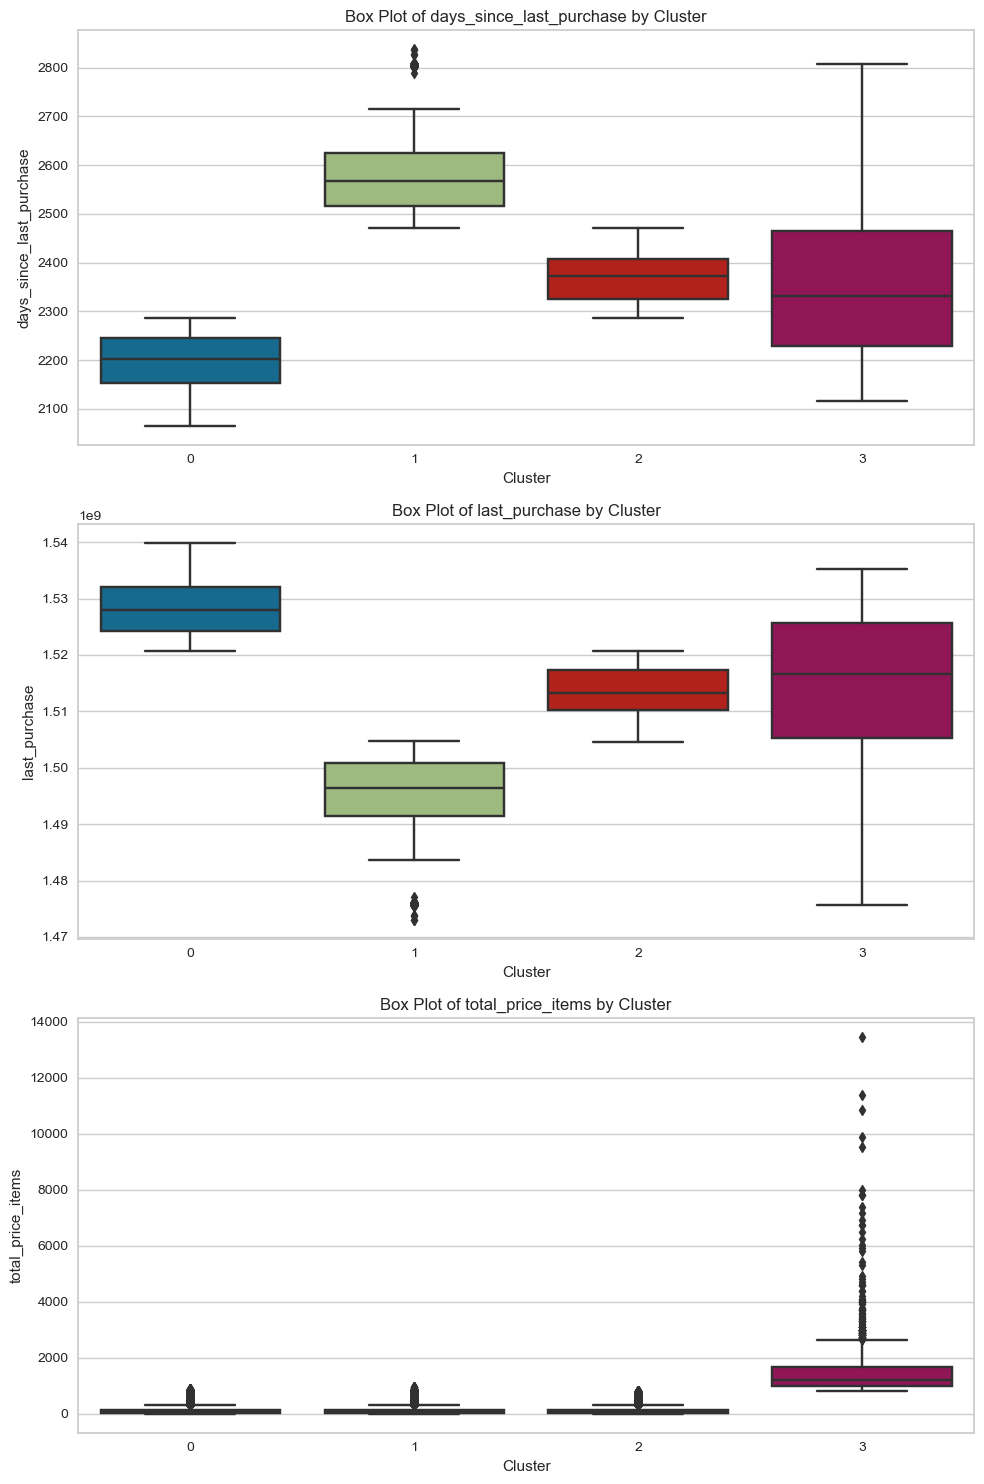

In [35]:
features = data_RFM.columns.difference(['cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(x='cluster', y=feature, data=data_RFM, ax=ax)
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

Looks like the total_price_items needs some more cleaning

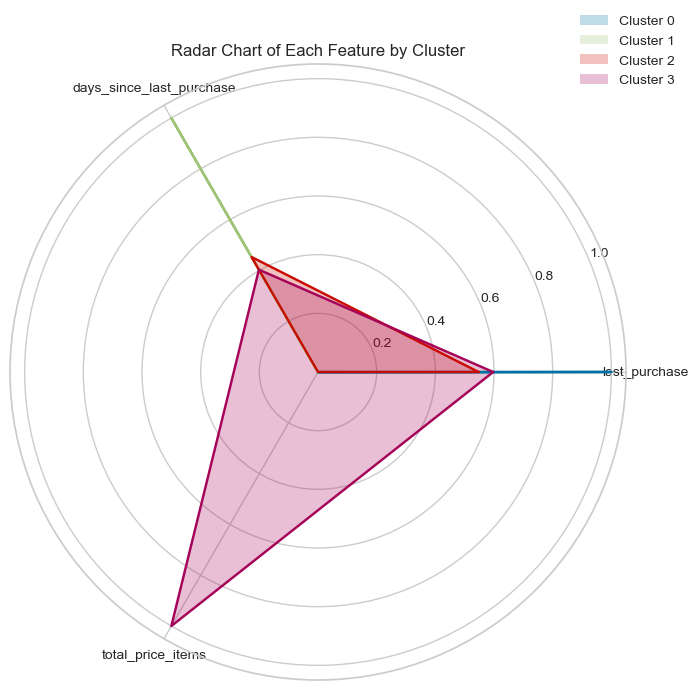

In [36]:
#RADAR
from sklearn.preprocessing import MinMaxScaler
# Calculate the mean of each feature for each cluster
cluster_means = data_RFM.groupby('cluster').mean()

# Normalize the feature values
scaler = MinMaxScaler()
cluster_means_normalized = pd.DataFrame(scaler.fit_transform(cluster_means), columns=cluster_means.columns)

# Number of clusters and features
num_clusters = cluster_means_normalized.shape[0]
num_features = cluster_means_normalized.shape[1]

# Create radar chart
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar plot
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

# Plot each cluster
for i in range(num_clusters):
    values = cluster_means_normalized.iloc[i].tolist()
    values += values[:1]  # Complete the loop
    ax.fill(angles, values, alpha=0.25, label=f'Cluster {i}')
    ax.plot(angles, values)

# Add feature labels to the plot
ax.set_xticks(angles[:-1])
ax.set_xticklabels(cluster_means.columns)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Display the radar chart
plt.title('Radar Chart of Each Feature by Cluster')
plt.show()

#### Cluster by feature

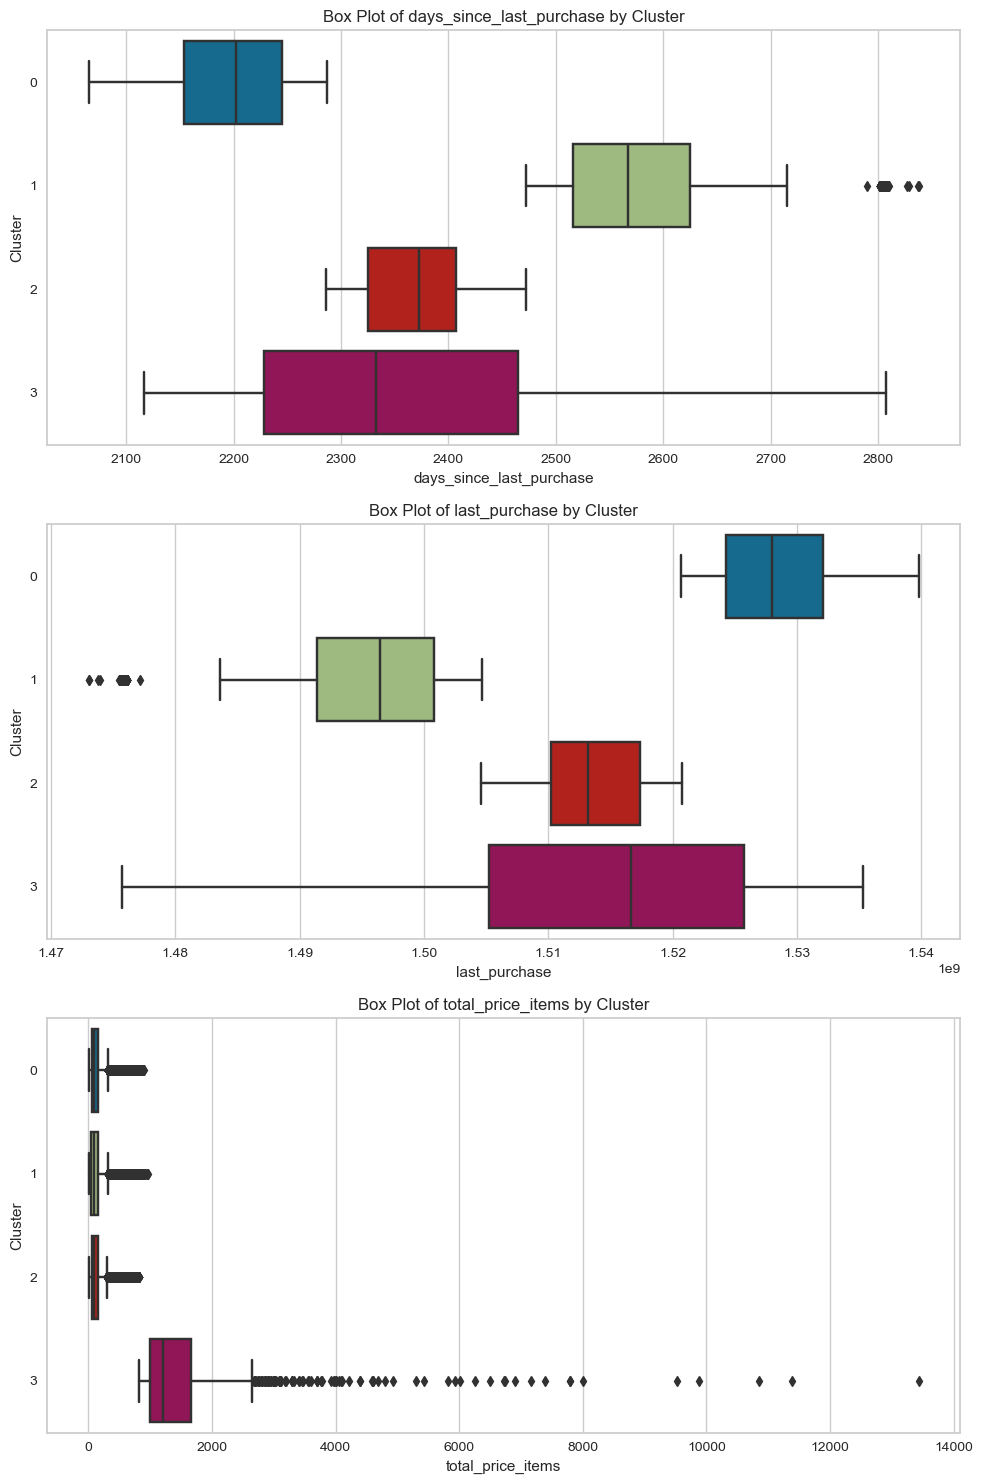

In [37]:
# Get the list of features (excluding the 'cluster' column)
features = data_RFM.columns.difference(['cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(y='cluster', x=feature, data=data_RFM, ax=ax, orient='h')
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel(feature)
    ax.set_ylabel('Cluster')

plt.tight_layout()
plt.show()

isn't it the same as the previous one ? 

#### Enrich the dataset

In [38]:
#joining two new columns
data_RFM_enriched = data_RFM.join(data['total_freight_value'], how='left')
data_RFM_enriched = data_RFM_enriched.join(data['total_orders'], how='left')

data_RFM_enriched.head()

,last_purchase,days_since_last_purchase,total_price_items,cluster,total_freight_value,total_orders
0,1.534792e+09,2123,729.62,0,172.42,17
1,1.519757e+09,2297,1000.85,3,171.82,9
2,1.530147e+09,2176,664.20,0,94.63,7
3,1.527853e+09,2203,806.61,0,316.11,7
4,1.518615e+09,2310,855.21,3,165.91,7


### Fit a new kmeans with new columns

#### New exploration

In [39]:
#drop the cluster to new clusterization
data_RFM_enriched.drop(columns='cluster')
display(data_RFM_enriched.head())

#is there NaN ? 
null_table(data_RFM_enriched)

,last_purchase,days_since_last_purchase,total_price_items,cluster,total_freight_value,total_orders
0,1.534792e+09,2123,729.62,0,172.42,17
1,1.519757e+09,2297,1000.85,3,171.82,9
2,1.530147e+09,2176,664.20,0,94.63,7
3,1.527853e+09,2203,806.61,0,316.11,7
4,1.518615e+09,2310,855.21,3,165.91,7


,Missing Values,Percentage of total
total_freight_value,676,0.7


In [42]:
#filling NAs
for col in data_RFM_enriched.columns:
    data_RFM_enriched=data_RFM_enriched.fillna(data_RFM_enriched[col].median())
#checking
null_table(data_RFM_enriched)

,Missing Values,Percentage of total


In [43]:
#StandardScale
scaler = StandardScaler()
data_RFM_enriched_scaled = scaler.fit_transform(data_RFM_enriched)

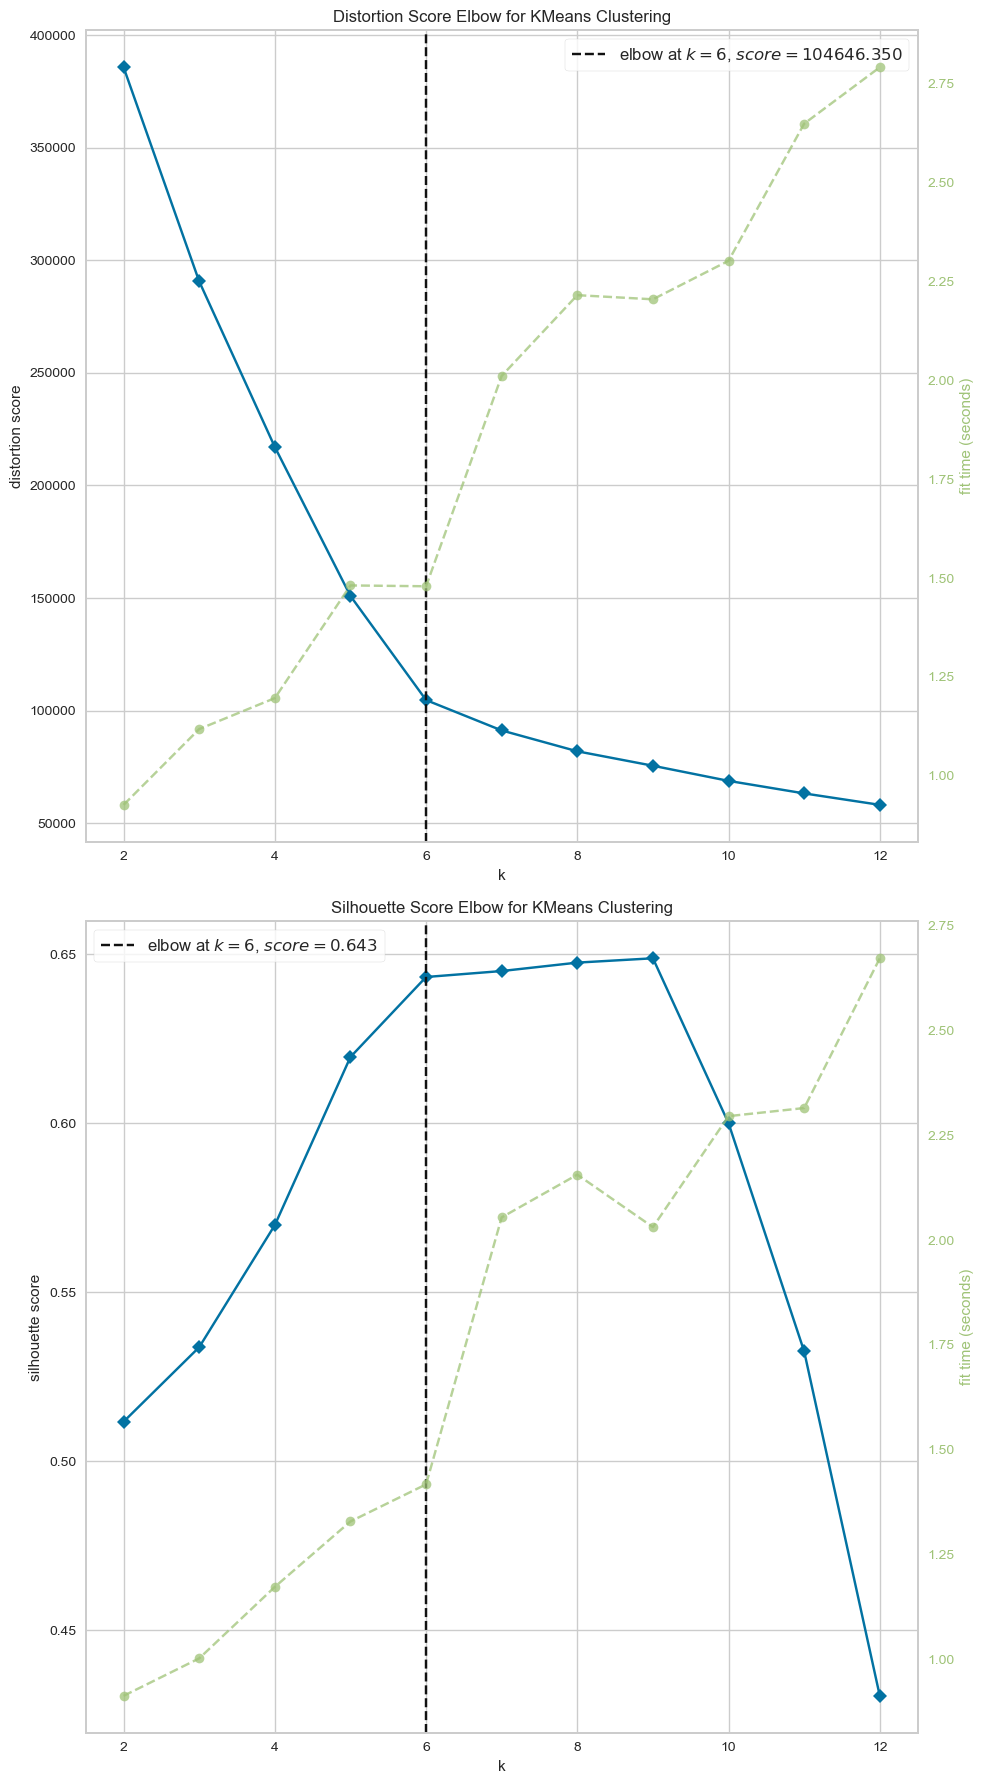

In [45]:
cluster_range = range(2, 13)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 18))

# Distortion Score (Elbow Method)
elbow_visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, ax=ax[0])
elbow_visualizer.fit(data_RFM_enriched_scaled)
elbow_visualizer.finalize()

# Silhouette Score
#km = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(KMeans(random_state=42, n_init=10), k=cluster_range, metric='silhouette', ax=ax[1])
visualizer.fit(data_RFM_enriched_scaled)
visualizer.finalize()

plt.tight_layout()
plt.show()

best k is 5 ? 6 ? 

In [46]:
best_k = 5
pipeline.set_params(kmeans__n_clusters=best_k)

#train_kmeans() ? still usefull if scaling needs to be done before ?

pipeline.fit(data_RFM_enriched_scaled)
data_RFM_enriched['cluster'] = pipeline.predict(data_RFM_enriched_scaled)
data_RFM_enriched

,last_purchase,days_since_last_purchase,total_price_items,cluster,total_freight_value,total_orders
0,1.534792e+09,2123,729.62,2,172.42,17
1,1.519757e+09,2297,1000.85,2,171.82,9
2,1.530147e+09,2176,664.20,2,94.63,7
3,1.527853e+09,2203,806.61,2,316.11,7
4,1.518615e+09,2310,855.21,2,165.91,7
...,...,...,...,...,...,...
96091,1.528282e+09,2198,223.00,3,19.44,1
96092,1.513553e+09,2369,59.00,0,17.66,1
96093,1.501889e+09,2504,143.80,1,18.90,1
96094,1.534106e+09,2131,30.00,3,8.37,1


In [47]:
data_cluster = data_RFM_enriched.groupby('cluster')
cluster_repartition = (data_cluster['cluster'].value_counts() / len(data_RFM))*100
cluster_repartition

cluster
0    37.414669
1    22.313104
2     3.115634
3    36.453130
4     0.703463
Name: count, dtype: float64

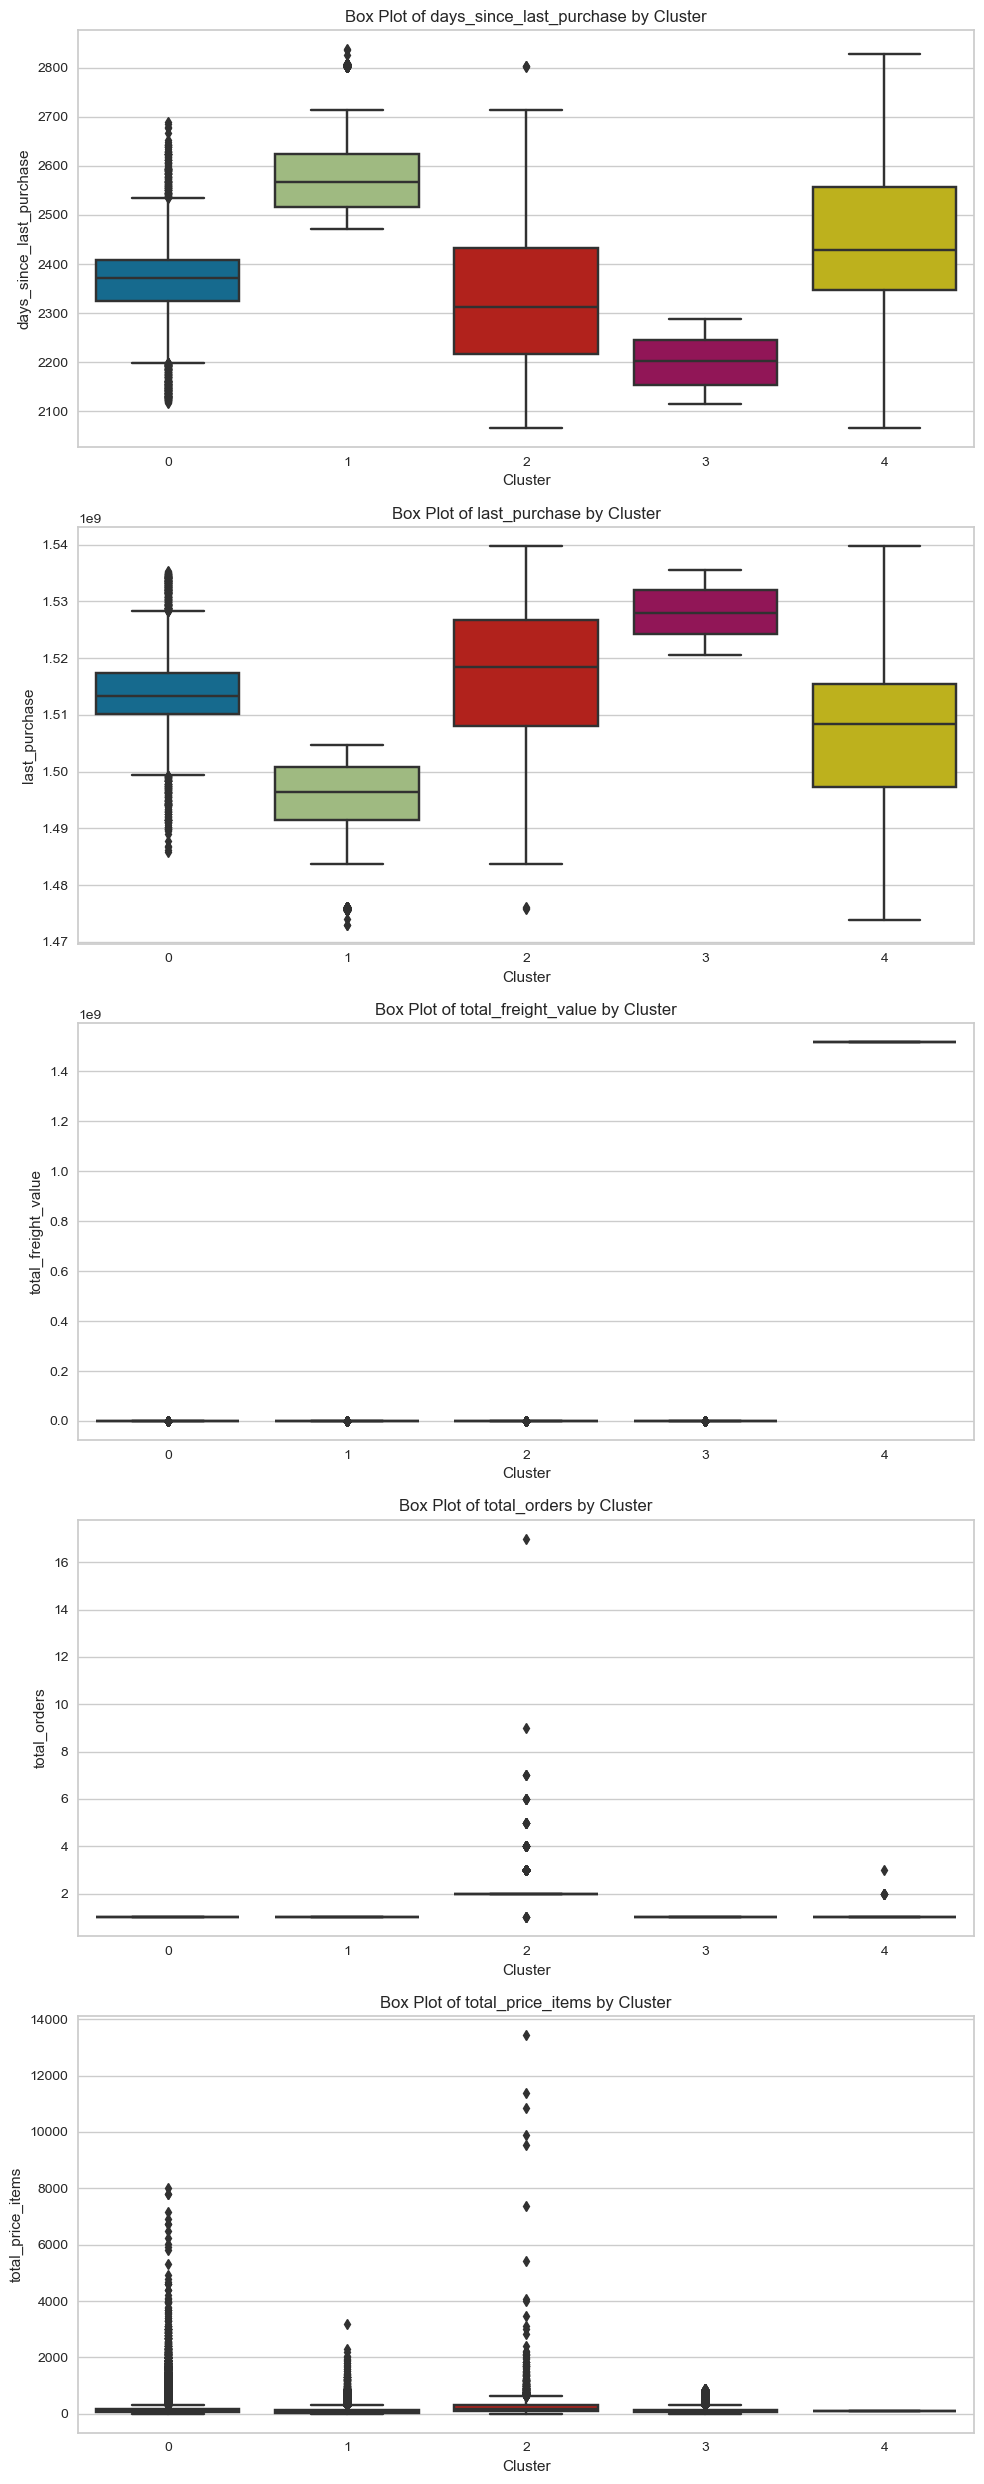

In [49]:
features = data_RFM_enriched.columns.difference(['cluster'])

# Number of features
num_features = len(features)

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Plot each feature
for i, feature in enumerate(features):
    ax = axes[i] if num_features > 1 else axes
    sns.boxplot(x='cluster', y=feature, data=data_RFM_enriched, ax=ax)
    ax.set_title(f'Box Plot of {feature} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

It seems that two clusters have very little population

#### DBSCAN approach

In [54]:
clustering = DBSCAN().fit(data_RFM_enriched_scaled)

clusterized = clustering.labels_
data_RFM_enriched['DBSCAN_cluter'] = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(clusterized)) - (1 if -1 in clusterized else 0)
n_noise_ = list(clusterized).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 24
Estimated number of noise points: 198


24 clusters is far from the first estimation obtained with silhouette score and Elbow method

In [55]:
data_cluster = data_RFM_enriched.groupby('DBSCAN_cluter')
DB_cluster_repartition = (data_cluster['DBSCAN_cluter'].value_counts() / len(data_RFM_enriched))*100
DB_cluster_repartition

DBSCAN_cluter
-1      0.206044
 0      0.096778
 1      0.058275
 2      0.027056
 3      0.003122
 4      1.125957
 5      1.088495
 6      0.532801
 7      0.056194
 8      0.005203
 9     36.453130
 10    21.946803
 11    35.960914
 12     0.301782
 13     0.317391
 14     1.391317
 15     0.261197
 16     0.098859
 17     0.017691
 18     0.014569
 19     0.005203
 20     0.010406
 21     0.008325
 22     0.006244
 23     0.006244
Name: count, dtype: float64

Only 6 clusters have 1% or more of the data, which is more coherent with the previously obtained estimations

The main problem is that DBSCAN is a density algorithm. Our data only contains 3000 clients with more than 1 purchase, but the clustering is made on all the dataset

#### HAC approach

Maybe include customer_unique_id ? Or scale the whole data and stop using a scaled version and unscaled version

In [ ]:
'''
#We need to sample data, as previous test showed that fitting the whole dataset takes too much time
sampled_data_RFM_enriched_scaled = data_RFM_enriched_scaled.sample(frac=0.05, random_state=42)
#We also need to sample in the same way our unscaled data, so as to attribute cluster coherently
'''
#OR
'''
sampled_data_RFM_enriched = data_RFM_enriched.sample(frac=0.05, random_state=42)
sampled_data_RFM_enriched.drop(columns=['cluster', 'DBSCAN_cluter'])
sampled_data_RFM_enriched_scaled = scaler.fit_transform(sampled_data_RFM_enriched)

'''

In [ ]:
'''
#made with AgglomerativeClustering
HAC_clustering = AgglomerativeClustering().fit(sampled_data_RFM_enriched_scaled)

HAC_clustering.labels_
sampled_data_RFM_enriched['HAC_cluster'] = HAC_clustering.labels_

data_cluster = sampled_data_RFM_enriched.groupby('HAC_cluster')
DB_cluster_repartition = (data_cluster['HAC_cluster'].value_counts() / len(sampled_data_RFM_enriched))*100
DB_cluster_repartition

#running time : 
'''

In [58]:
'''#made with AgglomerativeClustering
HAC_clustering = AgglomerativeClustering().fit(data_RFM_enriched_scaled)

HAC_clustering.labels_
data_RFM_enriched['HAC_cluter'] = HAC_clustering.labels_

data_cluster = data_RFM_enriched.groupby('HAC_cluter')
DB_cluster_repartition = (data_cluster['HAC_cluter'].value_counts() / len(data_RFM_enriched))*100
DB_cluster_repartition

#running time : almost 8 hours (with terrible results ?)'''

HAC_cluter
0    63.54687
1    36.45313
Name: count, dtype: float64

### Algorithm choice

Kmeans : 
 - Can be checked with silhouette and Elbow
 - Quick enough
 - Easily adjustable


DBSCAN : 
 - Harder to check
 - Fairly quick
 - harder to adjust

HAC : 
 - Infernally long
 - Difficult to adjust


We can see that the kmeans algorithm is better, faster, and more coherent regarding the data
We will therefore move on with this algorithm, with a clustering of 5

#### Cluster explanation : domain-wise

How to explain each cluster domain-wise


Relying on the boxplot made by cluster :
First clustering
 - Cluster 0 = last purchase
 - Cluster 1 = day since last purchase
 - Cluster 2 = 1%
 - Cluster 3 = total price items

Second clustering
 - 

### Export final dataset and model

In [59]:
import joblib

data_RFM_enriched.to_csv('data/data_with_clustering.csv', index = False)

# Save the model
kmeans_final = train_kmeans(StandardScaler, data_RFM_enriched, 5)
joblib_file = "kmeans_model.pkl"
joblib.dump(kmeans_final, joblib_file)